In [196]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

In [291]:
# Get data
data = pd.read_csv('../resources/data/data_fred_todate.csv')

# Get transformations
transformations = data.iloc[0][1:]
data = data.iloc[1:]

# Set date as index of df
data['sasdate'] = pd.to_datetime(data['sasdate'])
data.set_index('sasdate', inplace=True)

# Select only data from 1960-01-01 untill 2019-12-01
data = data.loc[(data.index >= '1960-01-01') & (data.index <= '2019-12-01')]

data.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1960-01-01,2548.137,2398.7,17.956,303094.4781,18763.67069,24.1712,25.3119,24.0877,34.0264,21.7598,...,17.903,11.676,2.22,2.57,2.13,NaN,7362.0,14063.0,75.4515,NaN
1960-02-01,2551.050,2400.9,18.034,307481.8465,18833.15808,23.9561,25.1684,24.0051,33.6388,21.4604,...,17.904,11.696,2.23,2.59,2.14,100.0,7396.0,14144.0,73.3363,NaN
1960-03-01,2555.924,2403.1,18.289,298983.9619,18812.41558,23.7410,25.0823,23.9775,33.6776,21.0362,...,17.937,11.703,2.24,2.69,2.14,NaN,7456.0,14239.0,71.5296,NaN
1960-04-01,2564.677,2411.8,18.572,301936.3997,19306.08721,23.5528,25.1398,24.0051,33.9101,21.0112,...,18.050,11.727,2.23,2.61,2.14,NaN,7582.0,14413.0,71.4718,NaN
1960-05-01,2570.841,2417.7,18.198,292564.7115,19017.76638,23.5259,25.2832,24.1704,34.1039,21.2108,...,18.042,11.758,2.24,2.64,2.14,93.3,7673.0,14559.0,71.6858,NaN


In [302]:
# Considering missing values and show highest 10. Only need to drop 5 series
print("MISSING: \n", data.isnull().sum().sort_values(ascending=False).head(6))

# Drop series with more than 10 missing values
to_drop = data.isnull().sum().sort_values(ascending=False).head(5).index
print("Dropping {}".format(to_drop))

# Dropping series
data = data.drop(to_drop, axis=1)

# Check indeed dropped
data.isnull().sum().sort_values(ascending=False).head(6)

MISSING: 
 ACOGNO           385
TWEXAFEGSMTHx    156
UMCSENTx         144
ANDENOx           97
VIXCLSx           30
COMPAPFFx          0
dtype: int64
Dropping Index(['ACOGNO', 'TWEXAFEGSMTHx', 'UMCSENTx', 'ANDENOx', 'VIXCLSx'], dtype='object')


RPI         0
BAAFFM      0
T10YFFM     0
T5YFFM      0
T1YFFM      0
TB6SMFFM    0
dtype: int64

In [260]:
def transform_series(code, series):
    # Codes correspond the following transformations:
    # 1: No transformation
    # 2: first difference
    # 3: second difference
    # 4: log
    # 5: log first difference
    # 6: log second difference
    # 7: first difference of log ratio

    if code == 1:
        return series
    elif code == 2:
        return series.diff()
    elif code == 3:
        return series.diff().diff()
    elif code == 4:
        return np.log(series)
    elif code == 5:
        return np.log(series).diff()
    elif code == 6:
        return np.log(series).diff().diff()
    elif code == 7:
        return (series.diff()/series.shift(1)).diff()
    else:
        raise ValueError('Transformation code not recognized')

In [261]:
# Transform data
for i, code in enumerate(transformations):
    print(code)
    data.iloc[:, i] = transform_series(code, data.iloc[:, i])

# Remove NA's 
data_noNA = data.dropna()
print(data_noNA.shape)
data_noNA.head(3)

print(data_noNA.aggregate(['min', 'max', 'mean', 'std']).T)

2451.778


ValueError: Transformation code not recognized

(717, 2)


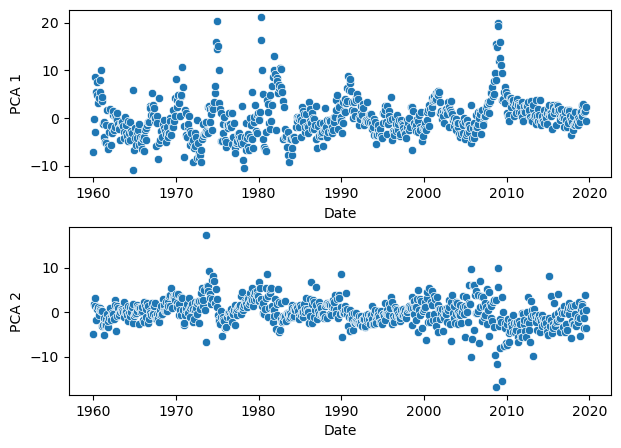

In [200]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_noNA)

# Create a PCA instance: pca
pca = PCA(n_components=2)

# Fit the PCA instance to the scaled samples
pca.fit(data_scaled)

# Transform the scaled samples: pca_features
pca_features = pca.transform(data_scaled)

# Print the shape of pca_features
print(pca_features.shape)

# Increased spacing between subplots
fig, ax = plt.subplots(2,1,figsize=(7,5))
plt.subplots_adjust(hspace=0.3)

# Add x and y label for both plots
ax[0].set_xlabel('Date')
ax[0].set_ylabel('PCA 1')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('PCA 2')

for i in range(2):
    sns.scatterplot(x = data_noNA.index, y=pca_features[:,i], ax=ax[i])

In [245]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE

def predict_pca(data, h_steps=1, response='CPIAUCSL', test_start='1985-01-01'):
    # Split into train and test sets with train ending at december 1984
    initial_train = data[:test_start]
    initial_test = data[test_start:]

    T_train = initial_train.shape[0]
    T_test = initial_test.shape[0]
    T = data.shape[0]

    # Split into X and y
    X = data
    y = data[response]

    # Shift y by h steps
    y = y.shift(h_steps)

    # Initialize the list of MSE's
    mse = []

    # t is where the test set start
    for t in range(T_train, T):

        # Split into X and y, dropping first h rows from training data to account for the shift
        X_train, y_train = X[h_steps:t], y[h_steps:t]
        X_test, y_test = X[t:(t + h_steps)], y[t:(t + h_steps)]
        
        # Scale the features by the slope of the regression line
        X_train = scale_X(X_train, y_train)

        # Apply PCA to the features
        pca = PCA(n_components=5)
        pca.fit(X_train)
        
        # Transform the training and test sets
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test.values)

        # Fit the model to the training data
        model = LinearRegression()
        model.fit(X_train_pca, y_train)    

        # Make predictions 1 step ahead
        y_pred = model.predict(X_test_pca)

        # Compute the MSE
        mse.append(MSE(y_test, y_pred))

    return mse

def scale_X(X_train, y_train):
    X_train = X_train.copy()
    T = X_train.shape[0]

    # Standardize the data
    scaler = StandardScaler()
    X_train_standardized = scaler.fit_transform(X_train)

    slopes = []

    for i in range(X_train.shape[1]):
        # Seperate the predictor from the rest of the data
        X_predictor = X_train_standardized[:,i].reshape(-1, 1)

        # Fit the model
        lr = LinearRegression(fit_intercept=True)
        lr.fit(X_predictor, y_train)

        # Obtain the slope coefficient which is the beta
        slope = lr.coef_
        slopes.append(slope)

    scaler_demean = StandardScaler(with_mean=False, with_std=False)
    X_train_demeaned = scaler_demean.fit_transform(X_train)

    for i, slope in enumerate(slopes):
        X_train_demeaned[:,i] = X_train_demeaned[:,i] * slope

    return np.sqrt(T) * X_train_demeaned

In [246]:
mse_list = predict_pca(data_noNA, 1)
print("Mean MSE:", np.mean(mse_list))

Mean MSE: 5.4777349499906824
